In [1]:
using SymPy
using LinearAlgebra
using Plots
using StaticArrays
using Combinatorics
using TimerOutputs
using LowRankApprox
using SpecialFunctions

In [2]:
include("factor.jl")
include("util.jl")
include("gegenbauer.jl")
include("hyperspherical.jl")

hypospherical (generic function with 1 method)

In [3]:
r = Sym("r")

r

In [12]:
dct_n=100
kern          = 1 / (1+r^2)
lkern         = lambdify(kern)
mat_kern(x,y) = 1 / (1+norm(x-y)^2)

d = 3
x_vecs = [randn(d)/6 for _ in 1:1000]
max_norm = max(maximum(norm.(x_vecs)), maximum(norm.(x_vecs)))
b = 2max_norm


1.3720863290904333

In [13]:
fkt_deg = 10
dover2 = convert(Int64, fkt_deg/2)
a_vals = zeros(fkt_deg+1) # kern's coefs in cheb poly basis
for i in 0:(fkt_deg)
    a_vals[i+1] = dct(lkern, i, b, dct_n)
end
pij = get_pij_table(fkt_deg+1)
transtable = zeros(Float64, fkt_deg+1, fkt_deg+1, fkt_deg+1)
for k3 in 0:dover2
    for k2 in 0:(dover2 - k3)
        for k1 in 0:(dover2-k3-k2)
            for i in 2(k1+k2+k3):fkt_deg
                transtable[k3+1, k2+1, k1+1] += (pij[i+1, 2(k1+k2+k3)+1] # here
                                    * a_vals[i+1]
                                    *(1-delta(0,i)/2) # here
                                    *multinomial([k1,k2,k3]...) #here
                                    *((1.0/b)^(2(k1+k2+k3))) #here
                                    *((-2.0)^k3)) #here
            end
        end
    end
end

In [14]:
tot = 0 
mapping = Dict()
for k3 in 0:fkt_deg
    for i in multiexponents(d, k3)
        mapping[i] = []
    end
end

for k3 in 0:dover2
    alphas = multiexponents(d, k3)
    for alpha in alphas
        for k2 in 0:(dover2-k3)
            betas = multiexponents(d, k2)
            for beta in betas
                for k1 in 0:(dover2-k3-k2)
                    gammas = multiexponents(d, k1)
                    for gamma in gammas
                        push!(mapping[alpha+2beta],(alpha, beta, gamma) )
                    end
                end
            end
        end
    end
end
U_mat = zeros(length(x_vecs), length(mapping))
V_mat = zeros(length(mapping),length(x_vecs))

rank = 0
for i in mapping
    rank += 1
    alphap2beta = i[1]
    for (x_idx, x_vec) in enumerate(x_vecs)
            U_mat[x_idx, rank] = (prod(x_vec .^ alphap2beta) )
    end
    triplets = i[2]
    for (y_idx, y_vec) in enumerate(x_vecs)
        for triplet in triplets
            alpha = triplet[1]
            beta  = triplet[2]
            gamma = triplet[3]
            k3 = sum(alpha)
            k2 = sum(beta)
            k1 = sum(gamma)
           V_mat[rank, y_idx] += ( prod(y_vec .^ alpha) 
            * prod(y_vec .^ (2gamma)) 
            * multinomial(alpha...)
            * multinomial(beta...)
            * multinomial(gamma...)
            *transtable[k3+1, k2+1, k1+1] )
        end
    end
end

guess = U_mat*V_mat
truth_mat  = mat_kern.(x_vecs, permutedims(x_vecs))
println(norm(truth_mat-guess,2)/norm(truth_mat,2))

0.0003581559732192586


In [15]:
qmat, rmat = qr(U_mat)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}}
Q factor:
1000×1000 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}}:
 -1.4396e-6    -8.62815e-7   -7.8327e-7    …   0.00378839    0.0138843
  3.41998e-5   -0.010641      0.0498711       -0.00211992    0.00191179
 -5.16408e-5   -0.000126884  -0.00120168       0.000298637   0.0430989
 -5.95451e-5   -3.54881e-5   -2.04469e-5      -0.000410789  -0.0246148
 -0.000595972  -0.000440741  -0.000511407      0.00187444    0.0463818
  0.0002172     0.00415336   -0.0437893    …  -0.00115538   -0.00173579
  8.33861e-5   -0.000381049   0.00465932      -0.00579667   -0.020479
 -0.000136349   0.00231695    0.00454606      -0.0020235    -0.0421626
  1.39165e-8   -4.26495e-6    7.72377e-6      -0.0112772    -0.0294371
 -2.20073e-7    3.03432e-5    0.000465773      0.00160039   -0.00171637
 -0.00325251   -0.0146438    -0.054895     …  -0.00227475   -0.0100762
 -9.87196e-7   -0.000241315  -0.00505955      -0.001017     -0.00248565
 -3.47171e-5   -1.2

In [16]:
qmat = qmat*Matrix(I, size(U_mat,1), size(U_mat,2))

1000×286 Matrix{Float64}:
 -1.4396e-6    -8.62815e-7   -7.8327e-7    …  -0.0216837    0.0222596
  3.41998e-5   -0.010641      0.0498711       -0.0295256   -0.00145301
 -5.16408e-5   -0.000126884  -0.00120168       0.0192856    0.0176488
 -5.95451e-5   -3.54881e-5   -2.04469e-5       0.0127533   -0.036909
 -0.000595972  -0.000440741  -0.000511407      0.0179893    0.021196
  0.0002172     0.00415336   -0.0437893    …  -0.00388528  -0.0584591
  8.33861e-5   -0.000381049   0.00465932      -0.140454     0.00541985
 -0.000136349   0.00231695    0.00454606      -0.00803773  -0.00739614
  1.39165e-8   -4.26495e-6    7.72377e-6      -0.0110542    0.0151746
 -2.20073e-7    3.03432e-5    0.000465773      0.0627463    0.0250101
 -0.00325251   -0.0146438    -0.054895     …  -0.0374327   -0.0240085
 -9.87196e-7   -0.000241315  -0.00505955      -0.0410893   -0.0460665
 -3.47171e-5   -1.29063e-5   -5.55529e-6      -0.0204143   -0.0146656
  ⋮                                        ⋱                ⋮
 

In [25]:
rbq = rmat*V_mat*qmat
svecs, svals = svd(rbq)
errs = []
for i in 1:50
    new_guess = qmat*svecs[:, 1:i]*diagm(svals[1:i])*transpose(svecs[:, 1:i])*transpose(qmat)
    push!(errs, norm(truth_mat-new_guess,2)/norm(truth_mat,2))
end

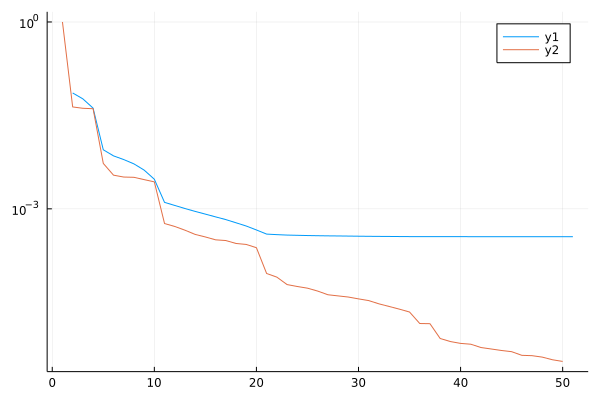

In [28]:
plot(2:51, errs, yaxis=:log10)
true_svecs, true_svals = svd(truth_mat)
plot!(1:50, true_svals[1:50]/true_svals[1], yaxis=:log10)


In [ ]:




truth_mat  = mat_kern.(x_vecs, permutedims(x_vecs))
guess = U_mat*V_mat
error = norm(guess-truth_mat,2)/norm(truth_mat, 2)
println("FKT Error: ", error)

# Generate trans table so we can generate orthogonal polynomials

In [ ]:
weight = r^(d-1)
polynomials = [Sym(1)]
polynomials[1] /= sqrt(integrate(weight*(polynomials[1]^2), (r,0,b)))
for i in 2:(fkt_deg+1)
    current = r^(i-1)
    for j in 1:(i-1)
        current -= polynomials[j] * (integrate(weight*polynomials[j]*r^(i-1), (r, 0, b))
                / integrate(weight*polynomials[j]^2, (r, 0, b)))
    end
    norm = sqrt(integrate(weight*current^2, (r,0,b)))
    push!(polynomials, expand(current/norm))
end
l_polys = []
for p in polynomials
    push!(l_polys, lambdify(p, [r]))
end

B = zeros((fkt_deg+1),(fkt_deg+1))
for i in 1:(fkt_deg+1)
    for j in 1:(fkt_deg+1)
        if j == 1
            B[i,j] = subs(polynomials[i], r=>0)
        else
            B[i,j] = polynomials[i].coeff(r^(j-1))
        end
    end
end
Binv = inv(B)

a_vals = zeros(fkt_deg+1) # kern's coefs in cheb poly basis
for i in 0:(fkt_deg)
    a_vals[i+1] = dct(lkern, i, b, dct_n)
end
pij = get_pij_table(fkt_deg+1)
transtable = zeros(Float64, fkt_deg+1, fkt_deg+1, fkt_deg+1)
for j in 0:dover2
    for new_i in 0:(fkt_deg-j)
        for n in j:(fkt_deg-max(new_i,j))
            if mod(j+n, 2) != 0
                continue
            end
            for m in max(new_i,j):(fkt_deg-n)
                if mod(m+j, 2) != 0
                    continue
                end
                for k3 in j:min(m,n)
                    if mod(k3+n, 2) != 0
                        continue
                    end
                    for i in (n+m):fkt_deg
                        m1 = convert(Int,((n-k3)/2))
                        m2 = convert(Int,((m-k3)/2))
                    transtable[j+1, new_i+1, n+1] += (pij[i+1, n+m+1] # here
                                        * a_vals[i+1]
                                        *Binv[m+1, new_i+1]
                                        * A(j, k3, 1//2)
                                        *(1-delta(0,i)/2) # here
                                        *multinomial([m1,m2,k3]...) #here
                                        *((1.0/b)^(n+m)) #here
                                        *((-2.0)^k3)) #here
                    end
                end
            end
        end
    end
end

In [ ]:
polynomials

In [ ]:
U_polys = Dict()
V_polys = Dict()

x = Sym("x")
# There is a u and v poly for every j, h, i
# For now we will ignore the harmonics and just inject the delta
for j in 0:dover2
    for new_i in 0:(fkt_deg - j)
        x_poly=0
        for n in j:2:(fkt_deg-max(new_i,j))
            x_poly += (x^n)*transtable[j+1, new_i+1, n+1]
        end
        U_polys[(j, new_i)] = x_poly
        V_polys[(j, new_i)] = subs(polynomials[new_i+1], r=>x)
    end
end

In [ ]:
integrations = Dict()
for j in 0:dover2
    N_k_alpha = gegenbauer_normalizer(d, j)
    for new_i in 0:(fkt_deg - j)
        for new_ip in 0:(fkt_deg - j)
            prod_poly =  U_polys[(j, new_i)]*V_polys[(j, new_ip)]
            integrations[(j, new_i, new_ip)] =  N_k_alpha*integrate(prod_poly*x^2, (x, 0,b))
        end
    end
end

In [ ]:
pole_count = 0
for j in 0:dover2
    for h in 1:length(get_multiindices(d, j))
        for new_i in 0:(fkt_deg - j)
            pole_count += 1
        end
    end
end

In [ ]:
Cmat = zeros(pole_count,pole_count)
pole_count = 0
integral_count=0
for j in 0:dover2
    for h in 1:length(get_multiindices(d, j))
        for new_i in 0:(fkt_deg - j)
            pole_count += 1
            pole_countp = 0
            for jp in 0:dover2
                for hp in 1:length(get_multiindices(d, jp))
                    for new_ip in 0:(fkt_deg - jp)
                       pole_countp += 1
                        if j != jp || h != hp 
                            continue
                        end
                        Cmat[pole_count, pole_countp] = integrations[(j, new_i, new_ip)]
                    end
                end
            end
        end
    end
end

In [ ]:
plt = plot()
all_evals = []
all_evecs = []
for smaller_deg in 4:2:12
    smaller_dover2 = convert(Int, smaller_deg/2)
    smaller_pole_count = 0
    for j in 0:smaller_dover2
        for h in 1:length(get_multiindices(d, j))
            for new_i in 0:(smaller_deg - j)
                smaller_pole_count += 1
            end
        end
    end
    evals, evecs = eigen(Cmat[1:smaller_pole_count, 1:smaller_pole_count]);
    push!(all_evals, evals)
    push!(all_evecs, evecs)
    eigenguess = transpose(V_mat)[:,1:size(evecs,1)]*evecs*diagm(evals)*conj(transpose(evecs))*conj(V_mat)[1:size(evecs,1),:]; 
    println(smaller_deg, " ", norm(eigenguess-truth_mat)/norm(truth_mat))
    
    revevals = max.(1e-6, sort(abs.(real(evals)))[end:-1:1])
    cap = min(60,length(revevals))
    plot!(1:cap, revevals[1:cap]/revevals[1], yscale=:log10)
end
plt

In [ ]:
# revevals = real(evals[end:-1:1])
evals = all_evals[end]
revevals = max.(1e-12, sort(abs.(real(evals)))[end:-1:1])

plot(1:length(svals), real(svals)/real(svals[1]), label="svd", yscale=:log10)
plot!(1:length(revevals), real(revevals)/real(revevals[1]), label="ev",yscale=:log10)

In [ ]:
x_vecs1d = [randn()/8 for _ in 1:2000]
truth_mat1d  = mat_kern.(x_vecs1d, permutedims(x_vecs1d))

svecs1d, svals1d = svd(truth_mat1d);
scatter(x_vecs1d, svecs1d[:, 1])
scatter!(x_vecs1d, svecs1d[:, 2])
scatter!(x_vecs1d, svecs1d[:, 3])
scatter!(x_vecs1d, svecs1d[:, 4], xlim=(-b/2,b/2), ylim=(-0.05,0.05))
# scatter!(x_vecs2d, svecs2d[:, 5], xlim=(-b/2,b/2), ylim=(-0.05,0.05))
# scatter!(x_vecs2d, svecs2d[:, 6])


In [ ]:
othermat_kern(x,y) =exp(-norm(x-y)^2)

othertruth_mat1d  = othermat_kern.(x_vecs1d, permutedims(x_vecs1d))

othersvecs1d, othersvals1d = svd(othertruth_mat1d);
scatter(x_vecs1d, othersvecs1d[:, 1])
scatter!(x_vecs1d, othersvecs1d[:, 2])
scatter!(x_vecs1d, othersvecs1d[:, 3])
scatter!(x_vecs1d, othersvecs1d[:, 4], xlim=(-b/2,b/2), ylim=(-0.05,0.05))
# scatter!(x_vecs2d, svecs2d[:, 5], xlim=(-b/2,b/2), ylim=(-0.05,0.05))
# scatter!(x_vecs2d, svecs2d[:, 6])


In [ ]:

for i in 1:length(x_vecs1d)
    if abs(othersvecs1d[i, 3]) < 1e-4
        println(x_vecs1d[i])
    end
end
scatter(x_vecs1d, othersvecs1d[:, 3], label="true")

scatter!(x_vecs1d, 
    [1.1000114xv^2-0.016861549xv-0.015763104 for xv in x_vecs1d] , 
    ) #xlim = (-0.03,0.03),
#     #ylim = (-0.03,0))



In [ ]:
x_vecs2d = [randn(2)/8 for _ in 1:2000]
truth_mat2d  = mat_kern.(x_vecs2d, permutedims(x_vecs2d))

svecs2d, svals2d = svd(truth_mat2d);
scatter([xv[1] for xv in x_vecs2d],[xv[2] for xv in x_vecs2d] , svecs2d[:, 1])


In [ ]:
scatter([xv[1] for xv in x_vecs2d],[xv[2] for xv in x_vecs2d] , svecs2d[:, 2], camera=(80,0))


In [ ]:
scatter([xv[1] for xv in x_vecs2d],[xv[2] for xv in x_vecs2d] , svecs2d[:, 3])


In [ ]:
scatter([xv[1] for xv in x_vecs2d],[xv[2] for xv in x_vecs2d] , svecs2d[:, 4])


In [ ]:
scatter([xv[1] for xv in x_vecs2d],[xv[2] for xv in x_vecs2d] , svecs2d[:, 5], camera=(0,0))


In [ ]:
scatter([xv[1] for xv in x_vecs2d],[xv[2] for xv in x_vecs2d] , svecs2d[:, 6], camera=(90,0))


In [ ]:
evecs = all_evecs[end]

In [ ]:
evalmag_to_evec = Dict()
for i in 1:length(evals)
    evalmag_to_evec[abs(evals[i])] = evecs[:,i]
end
sorted_evecs = sort(collect(evalmag_to_evec), by = x->x[1])[end:-1:1];

In [ ]:
start_i = 1
end_i = 5
plt = plot(1:size(evecs,1), real(sorted_evecs[1][2]))
for i in start_i+1:end_i
    plt = plot!(1:size(evecs,1), real(sorted_evecs[i][2]), xlim=(0,200), legend=false)
end
plt

In [ ]:
sorted_evecs[2][2][37:50]

In [ ]:
sorted_evecs[1][2][1:14]

In [ ]:
pole_count = 0
for j in 0:dover2
    for h in 1:length(get_multiindices(d, j))
        for new_i in 0:(fkt_deg - j)
            pole_count += 1
            println("entry ",pole_count, " is ", j,",", h,",", new_i)
        end
    end
end

In [ ]:


generate the same singular function plots except using eigenfunctions from cheb expansion
    (2d wrangling)